In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from random import shuffle

import time
import os

from ops import *
from utils import *

c:\users\eric\anaconda2\envs\hse_dl\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

Since the link to download the data didn't work I downloaded the data from a different source. The images were the wrong size and I was resizing them as they were loaded, which was painfully slow. Instead we'll try resizing them in advance and hopefully the model will train much faster.

In [167]:
# resize the images since they are the wrong size and shape
import cv2

file_list = os.listdir(DATA_PATH)
RESIZED_DATA_PATH = './celebA_resized2/'
# if the directory exists the images have already been resized and we can skip this step
if not os.path.exists(RESIZED_DATA_PATH):
    os.makedirs(RESIZED_DATA_PATH)
    
    
    counter = 0
    for f in file_list:
        # read the image in
        original_file_path = os.path.join(DATA_PATH, f)
        img = cv2.imread(original_file_path)
        
        # center crop it so the aspect ratio isn't distorted
        img = crop_center(img, 178, 178)
        
        # size the cropped image down
        img = cv2.resize(img, (64, 64))
        
        # write the image to disk
        cv2.imwrite(os.path.join(RESIZED_DATA_PATH, f), img)
        
        counter += 1
        if counter % 1000 == 0:
            print("%d images have been resized."%counter)     

## Writing generator function (1 point)

In [5]:
## improved version? original seems to work fine, let's keep this in case we need it later
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    # transpose conv 1
    net = deconv2d(h_in, [BATCH_SIZE, 8, 8, 512], name="g_conv_1")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_1")
    net = tf.nn.relu(net)
    
    # tranpose conv 2
    net = deconv2d(net, [BATCH_SIZE, 16, 16, 256], name="g_conv_2")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_2")
    net = tf.nn.relu(net)
    
    # tranpose conv 3
    net = deconv2d(net, [BATCH_SIZE, 32, 32, 128], name="g_conv_3")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_3")
    net = tf.nn.relu(net)
    
    # transpose conv 4
    net = deconv2d(net, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 16], name='g_conv_4')
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_4")
    net = tf.nn.relu(net)
    
    # transpose conv with stride 1 to smooth out artifacts as per Odena, et al., 2016
    h_out = tf.layers.conv2d_transpose(
            net,
            filters=N_CHANNELS,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=117932),
            name='g_conv_5'
        )

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [6]:
def discriminator(image, is_training, batch_norms=None):
    # images are cropped and resized in the get_image function rather than in the graph
    
    h0 = conv2d(image, 64, name="d_h0_conv")
    h0 = tf.contrib.layers.batch_norm(h0, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_0")
    h0 = tf.nn.leaky_relu(h0, alpha=0.2, name="d_lrelu_0")
    
    # conv 1 - 64x64x16
    h1 = conv2d(h0, 128, name="d_h1_conv")
    h1 = tf.contrib.layers.batch_norm(h1, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_1.0")
    h1 = tf.nn.leaky_relu(h1, alpha=0.2, name="d_lrelu_1.0")
    
    h2 = conv2d(h1, 256, name="d_h2_conv")
    h2 = tf.contrib.layers.batch_norm(h2, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_2.0")
    h2 = tf.nn.leaky_relu(h2, alpha=0.2, name="d_lrelu_2.0")
    
    h3 = conv2d(h2, 512, name="d_h3_conv")
    h3 = tf.contrib.layers.batch_norm(h3, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_3.0")
    h3 = tf.nn.leaky_relu(h3, alpha=0.2, name="d_lrelu_3.0")
    
    h4 = tf.contrib.layers.flatten(h3)
    
    h4 = tf.layers.dense(
            h4,
            1024,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=117),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name="d_fc1"
        )
    h4 = tf.contrib.layers.batch_norm(h4, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_5")
    h4 = tf.nn.relu(h4, name='d_fc1_relu')
    
    linear_out = tf.layers.dense(
            h4,
            1,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=118),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name="d_fc2"
        )
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [7]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, 64, 64, N_CHANNELS], name="images_placeholder")
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [8]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [9]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

# get the batch norm updates so we can run them
gen_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="G")
dis_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="D")

Load data:

In [10]:
data = glob(os.path.join(RESIZED_DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"
print("Data:", len(data))

Data: 112713


Functions for training and evaluations.

In [11]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

Image Shape: (64, 64, 3)


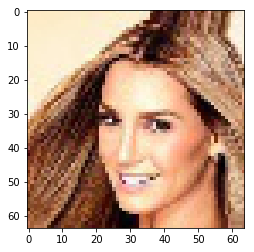

In [12]:
# make sure the input is properly resized
idx = 0
batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]

print("Image Shape:", batch[0].shape)
plt.imshow(inverse_transform(batch[0]))
plt.show()

In [13]:
def train(sess, load_dir=None, save_frequency=50, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2, 
          print_frequency=25,
          show_samples=True,
          gen_extra_update_ops=gen_extra_update_ops, 
          dis_extra_update_ops=dis_extra_update_ops):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    # shuffle the input data
    shuffle(data)
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE, resize=False) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
            
            # Update D network
            sess.run([d_optim, dis_extra_update_ops], feed_dict={images: batch_images, z: batch_z, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run([g_optim, gen_extra_update_ops],
                    feed_dict={z: batch_z, is_training: True})
            
            counter += 1
            # over 100,000 images means a lot of batches and we don't need to see the results for each batch
            # this will also speed up training hopefully
            if np.mod(counter, print_frequency) == 1:
                errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
                errD_real = d_loss_real.eval({images: batch_images, is_training: False})
                errG = g_loss.eval({z: batch_z, is_training: False})

                print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                    epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [8, 8],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.jpg'.format(epoch, idx)))
                print("Sample")
                
                # instead of waiting for the samples to be saved to a file let's display one right here
                if show_samples:
                    print("\n")
                    plt.imshow(inverse_transform(samples[0]))
                    plt.show()
                    print("\n\n\n")

My laptop GPU did not have enough memory to handle training this and it was very slow to train on the CPU, especially when the images were resized at run-time. Due to this the training had to be stopped and started repeatedly and the kernel also crashed several times. 

Hopefully resizing the images in advance will speed the process up.

In [15]:
# use first config to train on CPU, second on GPU
config=tf.ConfigProto(device_count={'GPU': 0})
# config = tf.ConfigProto()

Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model
Loaded checkpoints
Epoch: [ 0] [  24/1761] time: 1269.5427, d_loss: 1.28625154, g_loss: 1.11968470
Epoch: [ 0] [  49/1761] time: 2510.7877, d_loss: 1.55836713, g_loss: 1.15359628
Saved model
Epoch: [ 0] [  74/1761] time: 3754.0980, d_loss: 1.44937444, g_loss: 0.73475164
Epoch: [ 0] [  99/1761] time: 4990.1096, d_loss: 1.29136145, g_loss: 0.87732458
Saved model
Sample




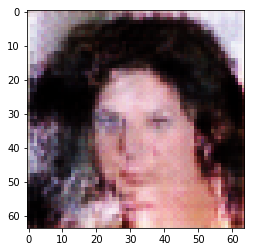





Epoch: [ 0] [ 124/1761] time: 6234.4366, d_loss: 1.45334482, g_loss: 0.70528209
Epoch: [ 0] [ 149/1761] time: 7462.8594, d_loss: 1.50758410, g_loss: 0.83052516
Saved model
Epoch: [ 0] [ 174/1761] time: 8700.3580, d_loss: 1.31799459, g_loss: 0.91391575
Epoch: [ 0] [ 199/1761] time: 9928.7756, d_loss: 1.24410009, g_loss: 1.12818325
Saved model
Sample




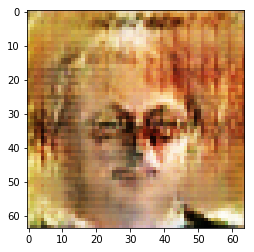





Epoch: [ 0] [ 224/1761] time: 39911.1452, d_loss: 1.49042392, g_loss: 0.55474019
Epoch: [ 0] [ 249/1761] time: 40417.1090, d_loss: 1.39767504, g_loss: 1.14543128
Saved model
Epoch: [ 0] [ 274/1761] time: 40886.1102, d_loss: 1.26877403, g_loss: 0.77536613
Epoch: [ 0] [ 299/1761] time: 41352.1162, d_loss: 1.26379013, g_loss: 0.88052368
Saved model
Sample




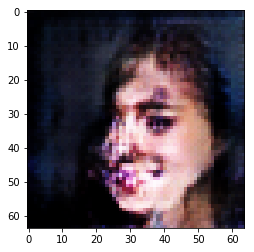





Epoch: [ 0] [ 324/1761] time: 41822.0124, d_loss: 1.37864077, g_loss: 0.79361200
Epoch: [ 0] [ 349/1761] time: 42292.2130, d_loss: 1.43643153, g_loss: 0.78886080
Saved model
Epoch: [ 0] [ 374/1761] time: 42770.6876, d_loss: 1.44576633, g_loss: 1.03364825
Epoch: [ 0] [ 399/1761] time: 43247.2384, d_loss: 1.36910093, g_loss: 0.98752433
Saved model
Sample




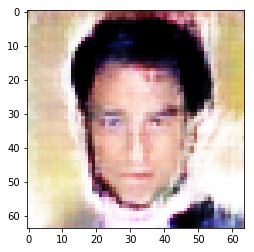





Epoch: [ 0] [ 424/1761] time: 43739.3477, d_loss: 1.42715490, g_loss: 0.73653412
Epoch: [ 0] [ 449/1761] time: 44217.6574, d_loss: 1.34329081, g_loss: 0.91704458
Saved model
Epoch: [ 0] [ 474/1761] time: 44697.5730, d_loss: 1.44414806, g_loss: 0.78099006


In [ ]:
with tf.Session(config=config) as sess:
    train(sess, load_dir='checkpoint3', save_dir='checkpoint3', show_samples=True, model_name='dcgan1.model', n_generator_update=2)

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

These faces aren't great, but they are better than the last batch.

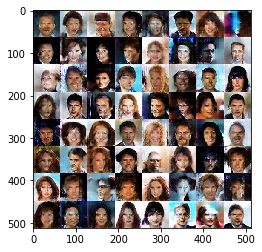

In [222]:
from PIL import Image
# look at the samples
img = Image.open("sample_faces/train_01_0038.jpg")
plt.imshow(img)
plt.show()

Now let's look at some randomly generated images a bit larger...

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


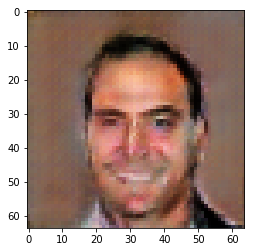

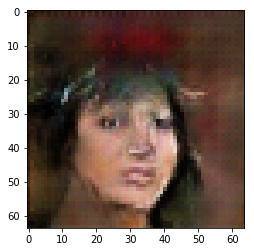

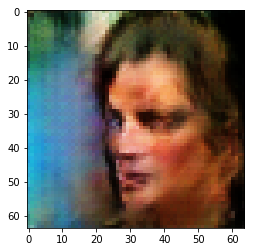

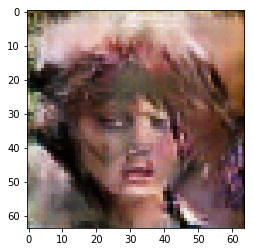

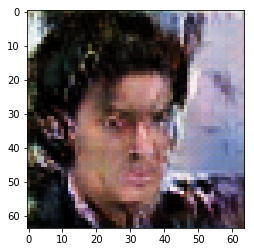

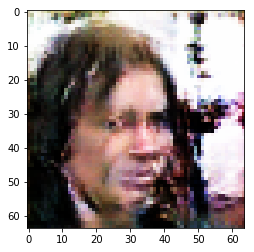

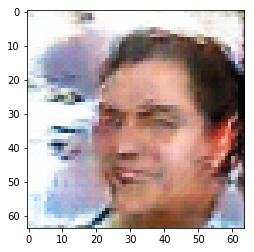

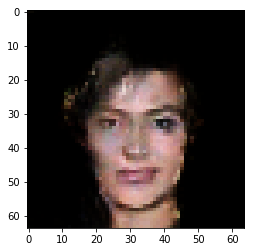

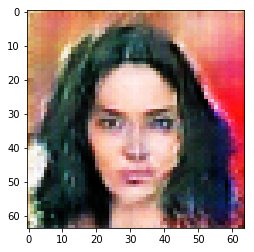

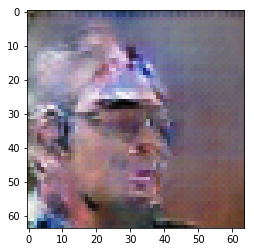

In [221]:
# after 3 epochs
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )

for sample in samples[:10]:
    plt.imshow(inverse_transform(sample))
    plt.show()

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


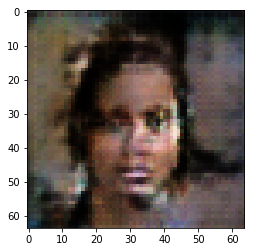

In [15]:
# after 2 epochs
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    
plt.imshow(inverse_transform(samples[10]))

## Face interpolation (1 point)

Here I create multiple random vectors and add them to lists depending on whether they generate smiles or not.

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [186]:
# initialize two random vectors
z1 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)

# initialize a range of alphas
alphas = np.linspace(0, 1, BATCH_SIZE)

batchz = []

# loop through and create our batch of vectors
for alpha in alphas:
    batchz.append((alpha * z1) + ((1 - alpha) * z2))
    
# convert the list into a numpy array    
batchz = np.squeeze(np.array(batchz))

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


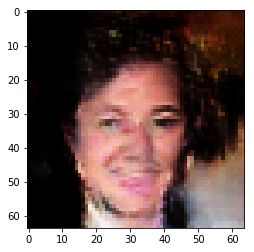

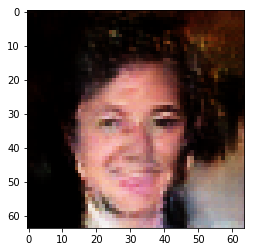

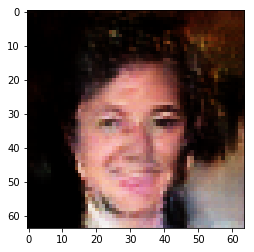

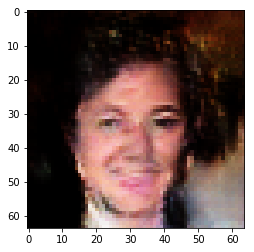

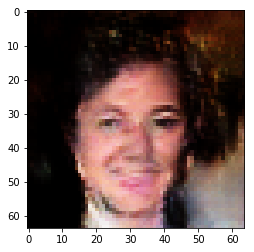

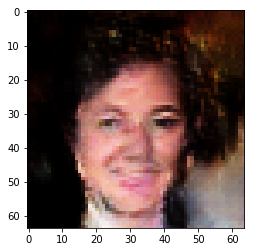

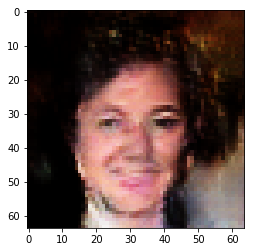

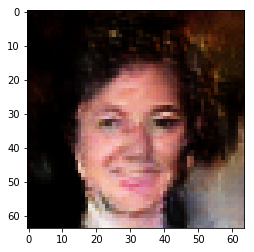

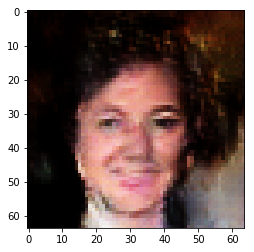

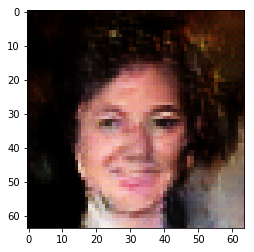

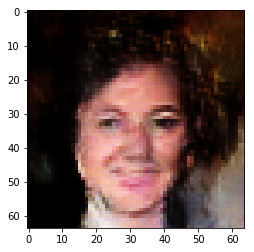

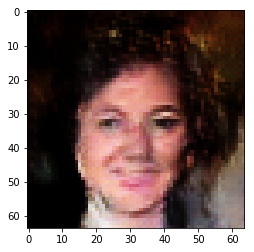

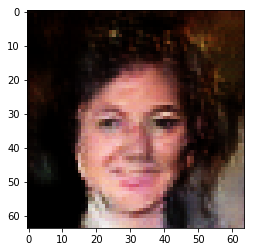

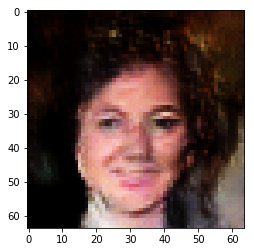

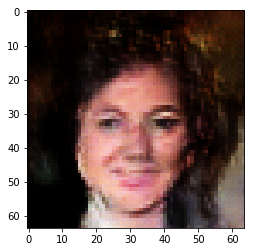

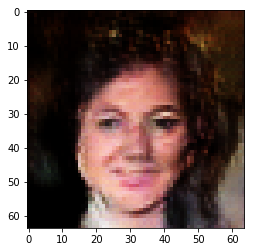

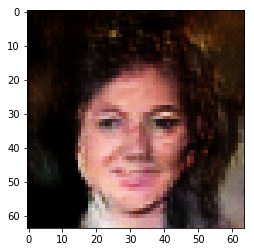

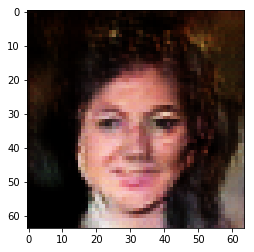

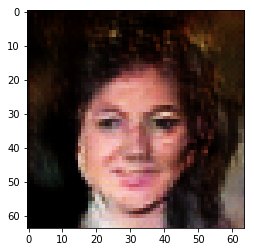

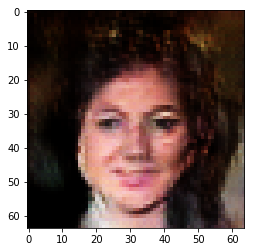

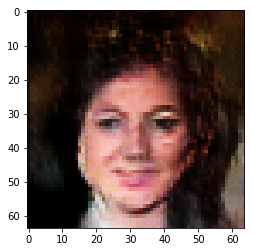

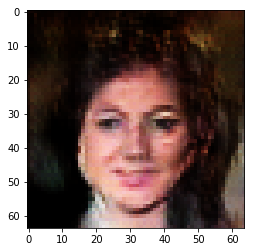

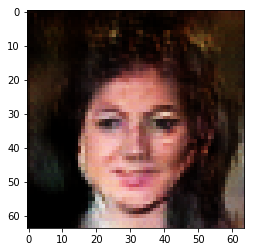

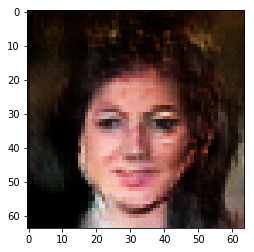

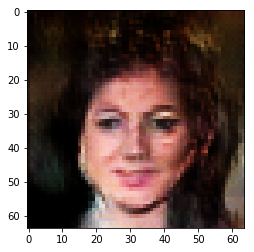

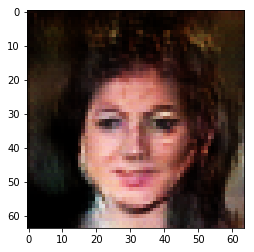

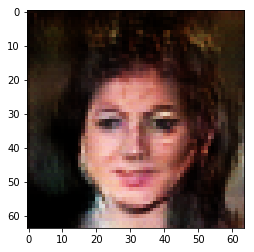

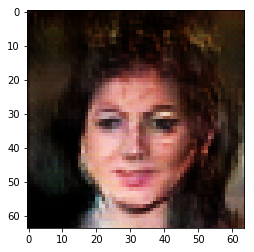

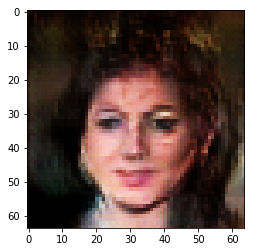

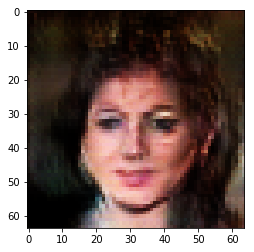

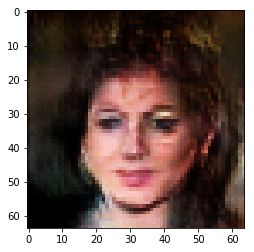

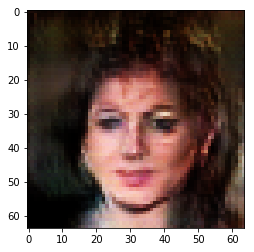

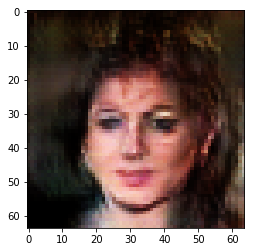

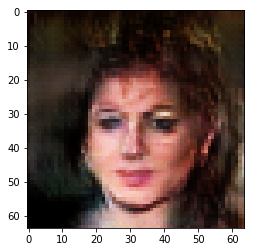

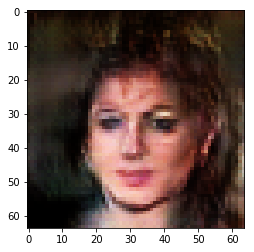

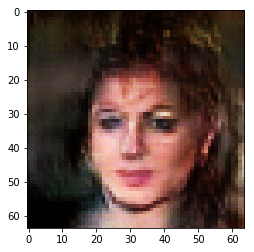

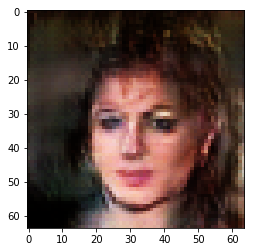

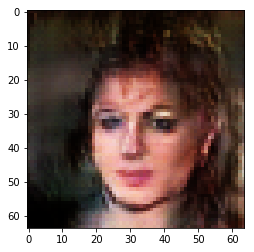

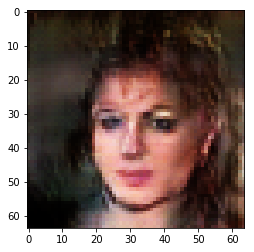

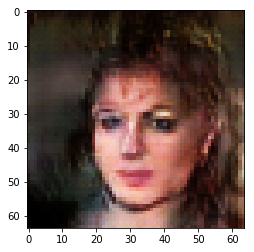

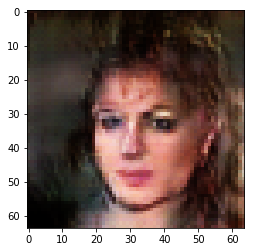

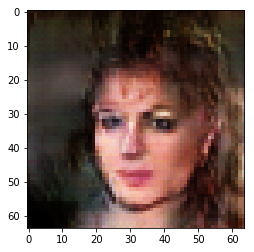

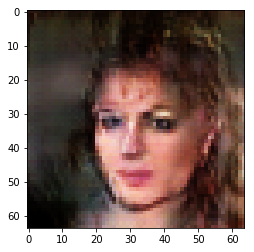

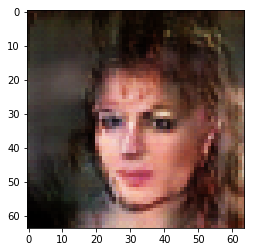

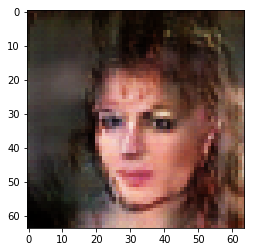

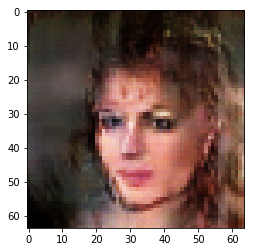

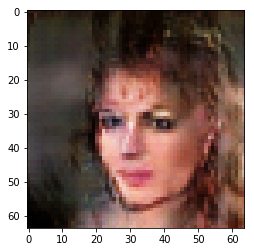

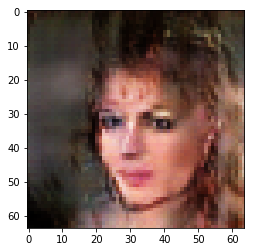

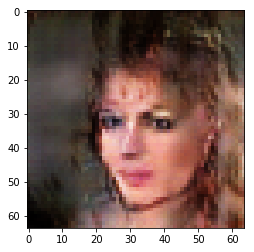

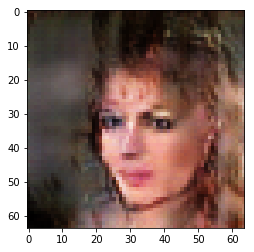

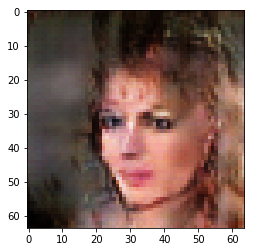

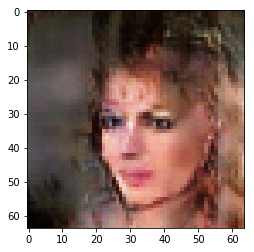

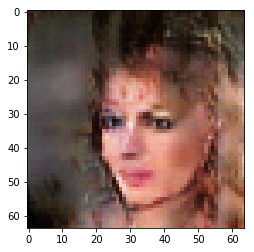

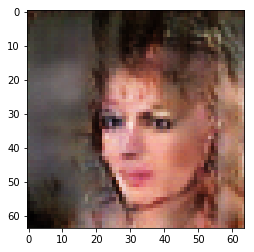

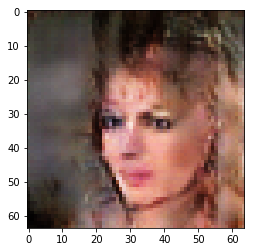

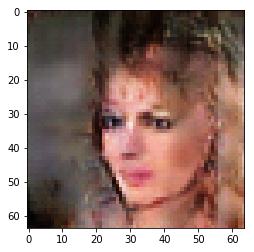

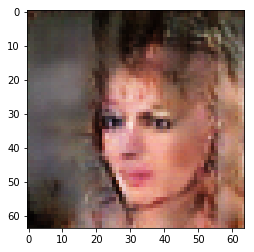

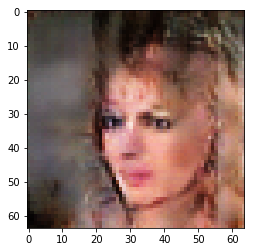

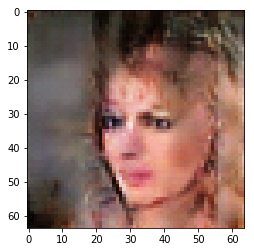

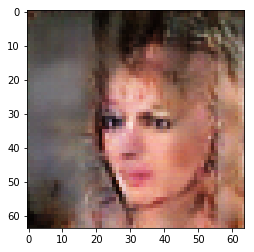

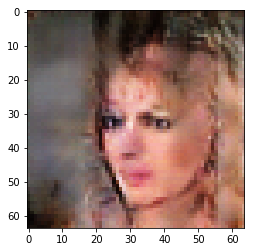

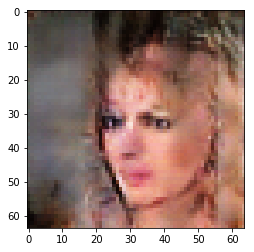

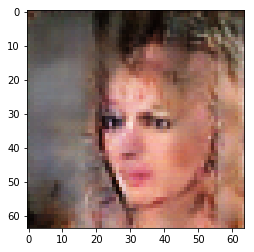

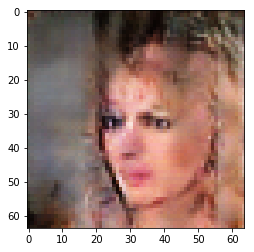

In [187]:
# create images with our vectors as input
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

## Adding a smile (1 point + 1 point for good results)

In [188]:
# init lists to add our vectors to
not_smile_vectors = []
smile_vectors = []

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


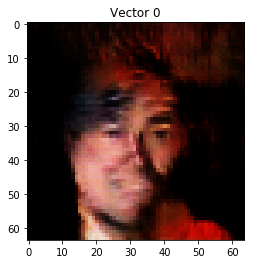

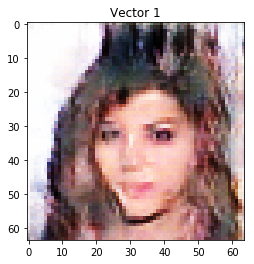

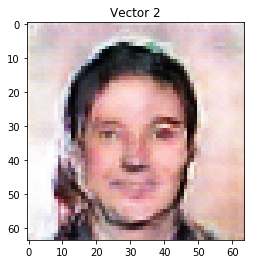

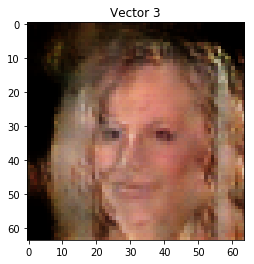

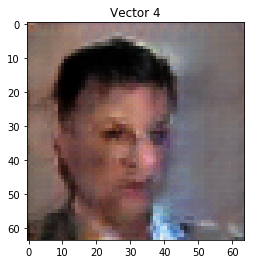

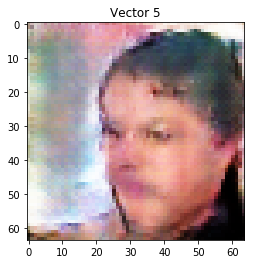

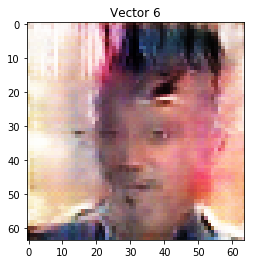

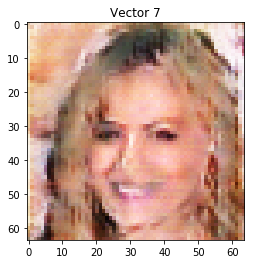

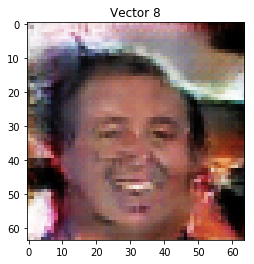

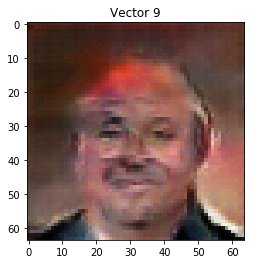

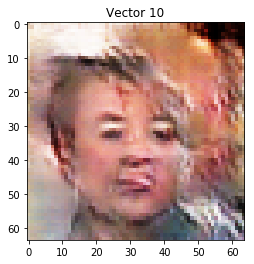

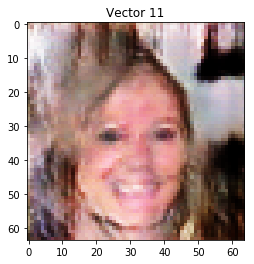

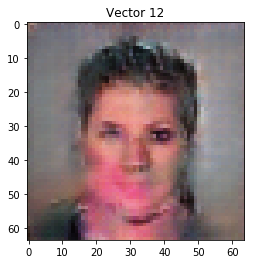

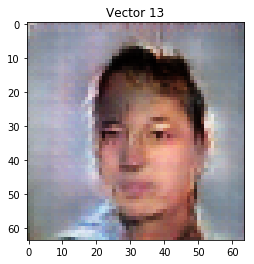

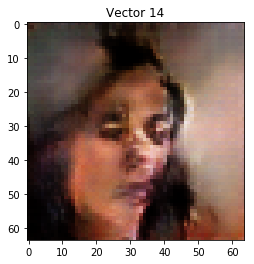

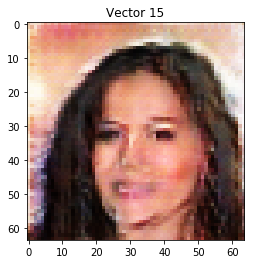

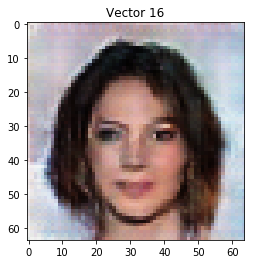

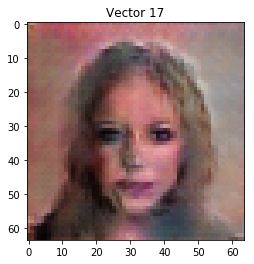

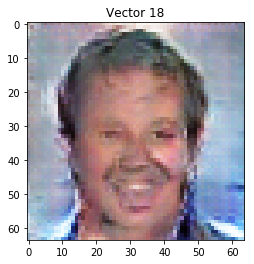

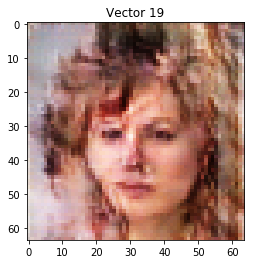

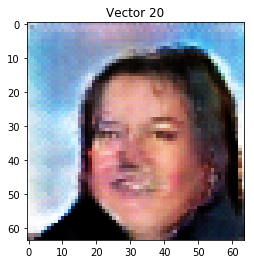

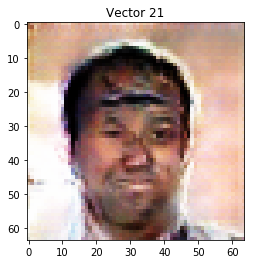

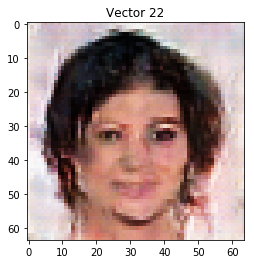

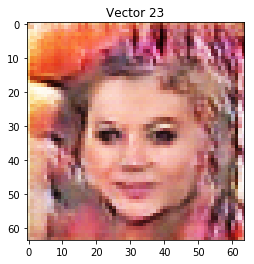

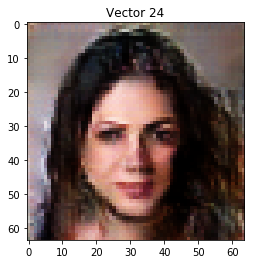

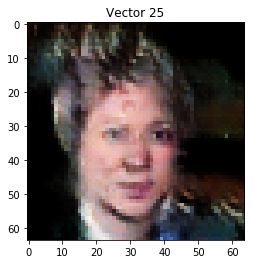

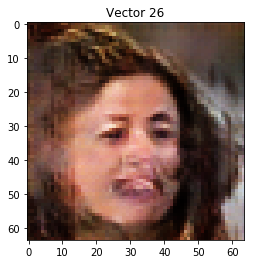

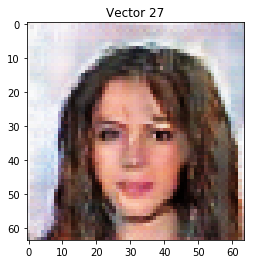

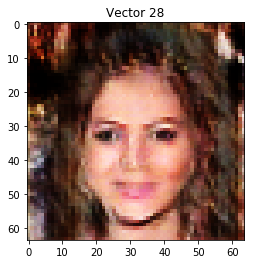

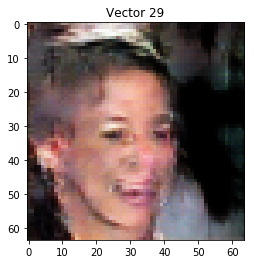

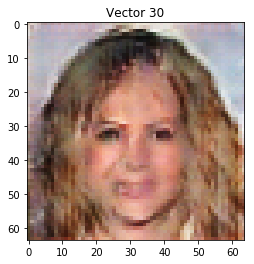

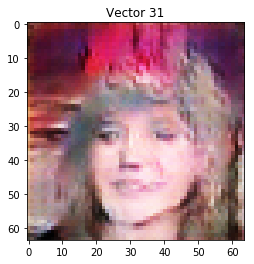

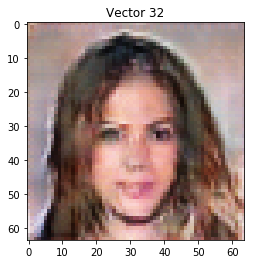

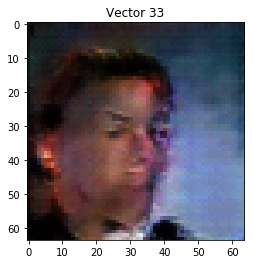

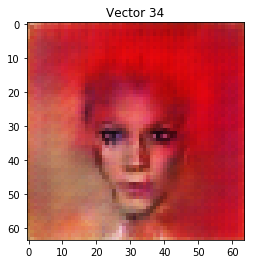

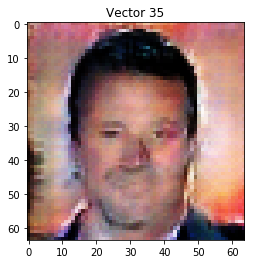

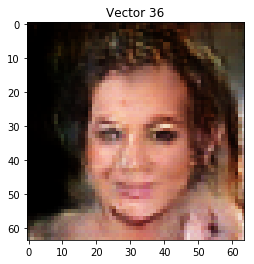

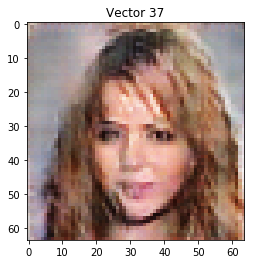

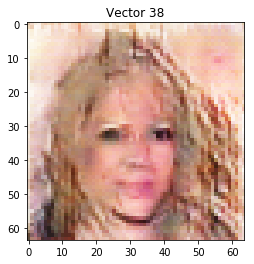

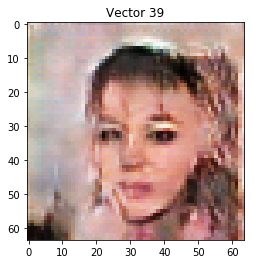

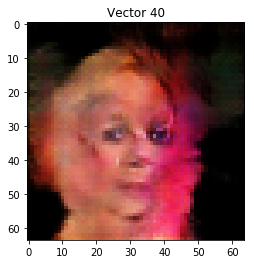

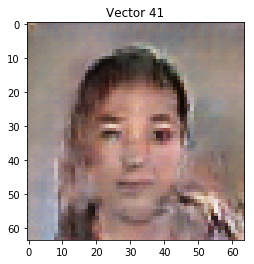

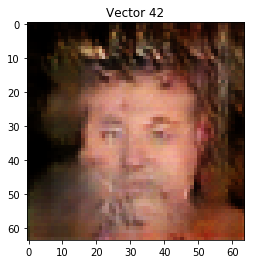

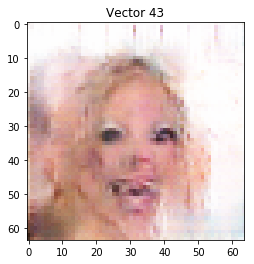

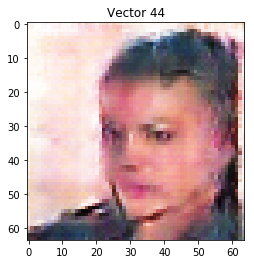

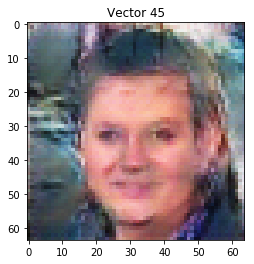

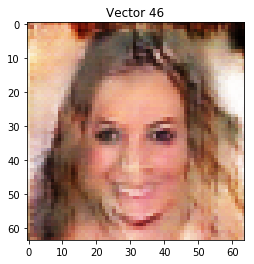

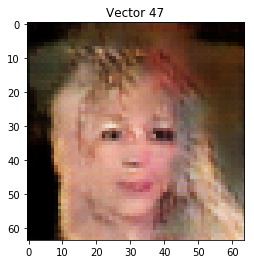

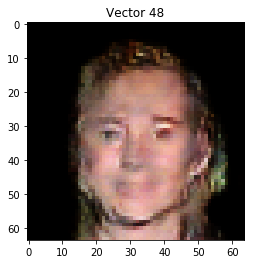

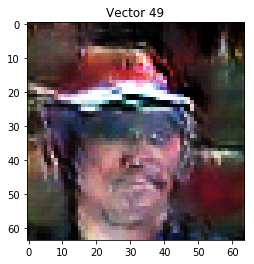

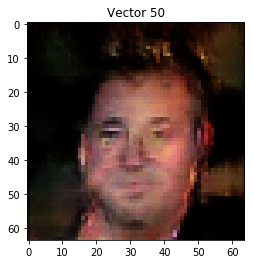

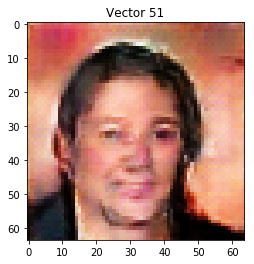

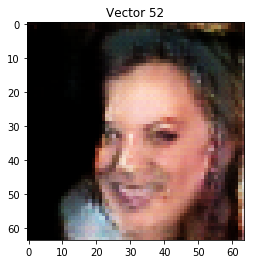

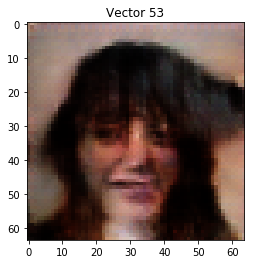

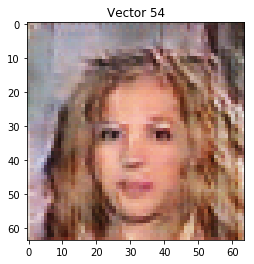

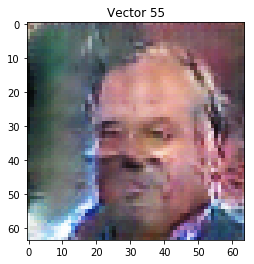

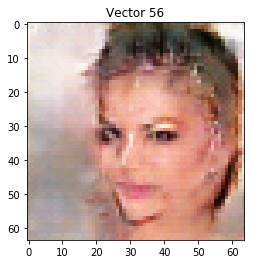

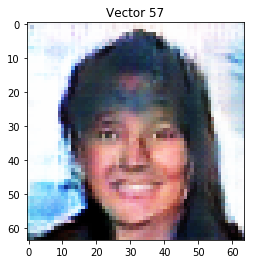

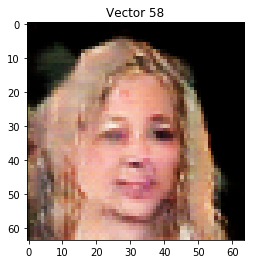

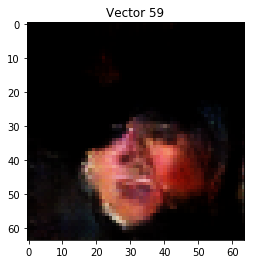

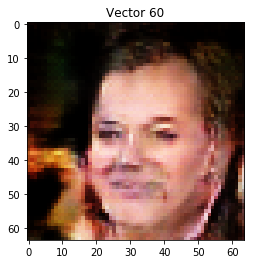

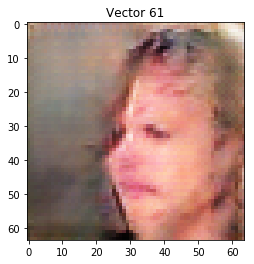

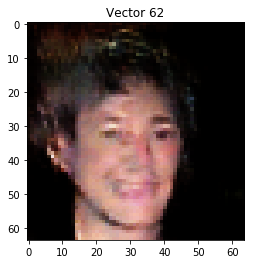

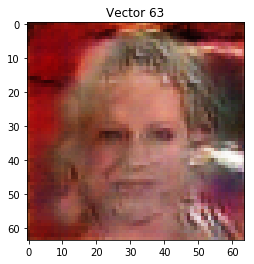

In [202]:
batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

# create images with our vectors as input
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    
# look at the images we created    
for i, image in enumerate(samples):
    plt.imshow(inverse_transform(image))
    plt.title("Vector " + str(i))
    plt.show()

In [212]:
# the vectors were added to our list as they were created, seeing which created smiles and which did not
# this lists were created backwards, which is addressed by subtracting the smile vector instead of adding it
not_smile_vectors.append(batch_z[24])
# smile_vectors.append(batch_z[52])

In [213]:
print("Smile:", len(smile_vectors))
print("Not Smile:", len(not_smile_vectors))

Smile: 9
Not Smile: 9


Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

In [214]:
# convert the lists to arrays and squeeze them
not_smile_array = np.squeeze(np.array(not_smile_vectors))
smile_array = np.squeeze(np.array(smile_vectors))

In [215]:
# take the mean of the arrays on axis 0
smile = smile_array.mean(axis=0)
not_smile = not_smile_array.mean(axis=0)

In [216]:
# subtract the not smile from the smile
smile_vector = smile - not_smile

In [217]:
# create some random vectors to test
batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

# add the smile vector
smile_batch = batch_z + smile_vector

# just for fun let's do another batch where we subtract the smile vecot
not_smiles_batch = batch_z - smile_vector

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


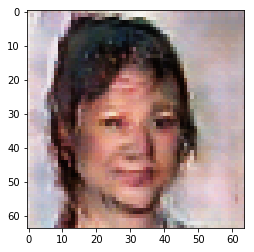

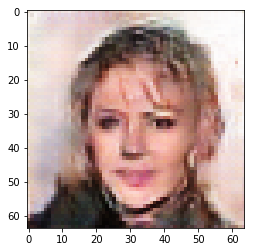

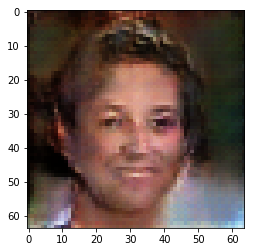

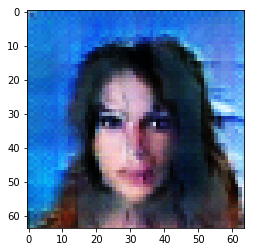

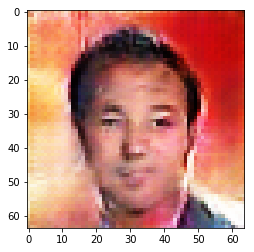

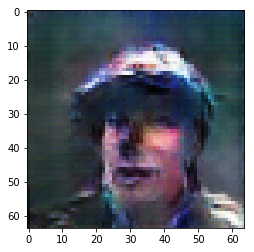

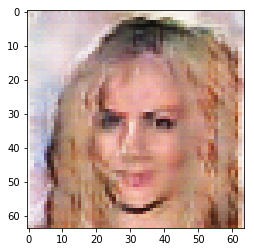

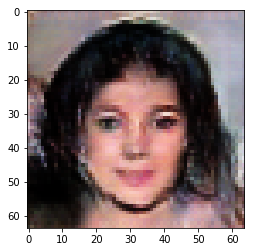

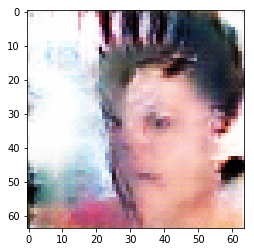

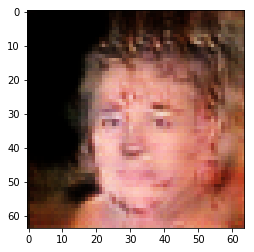

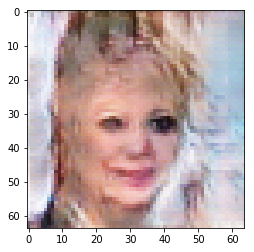

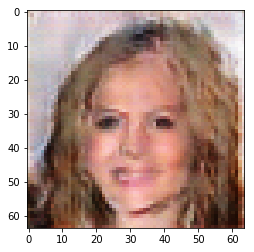

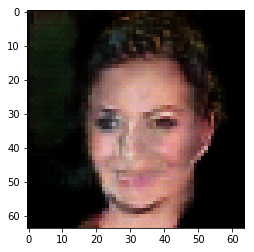

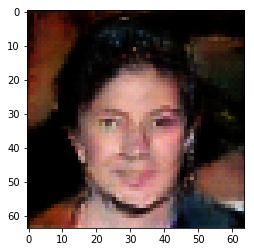

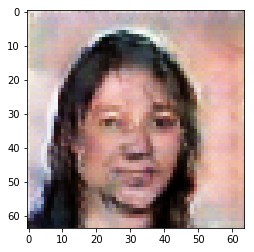

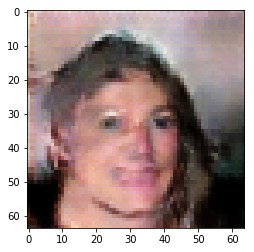

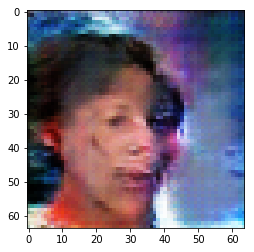

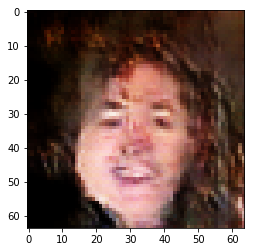

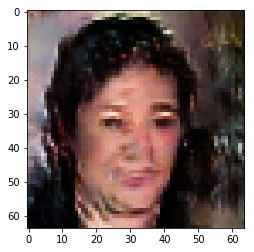

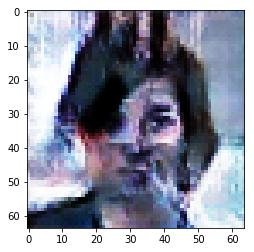

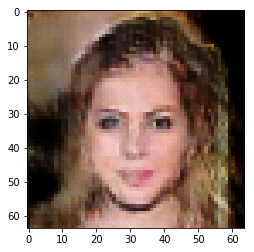

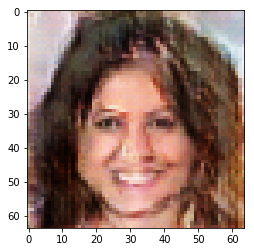

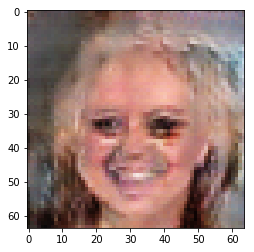

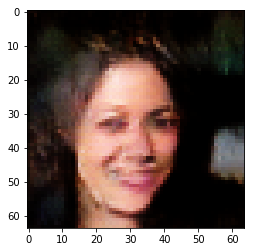

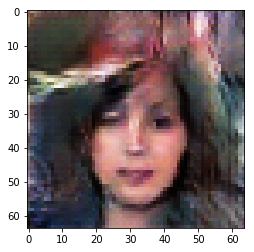

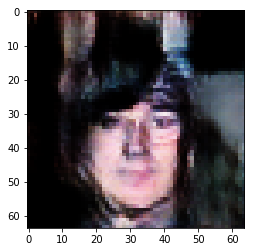

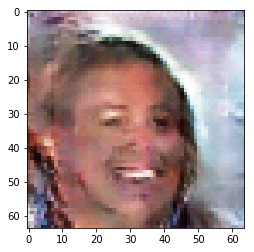

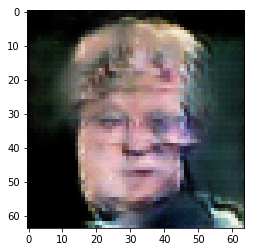

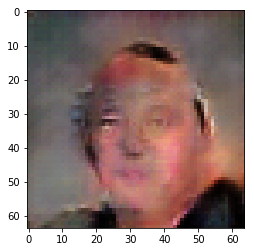

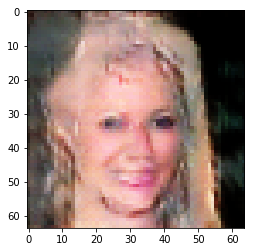

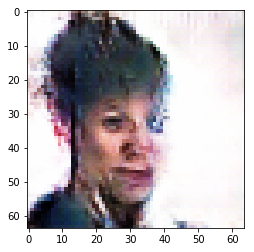

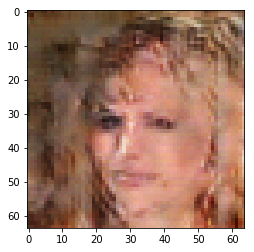

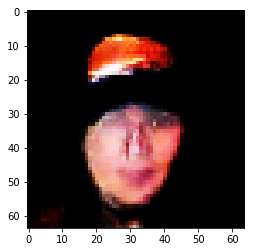

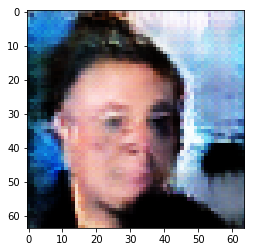

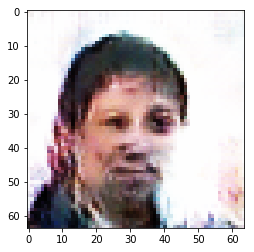

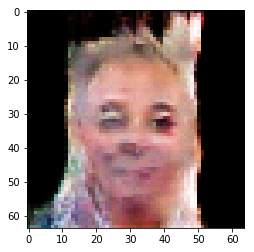

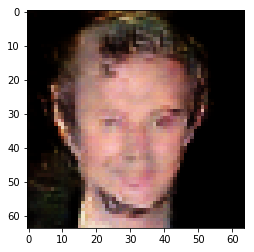

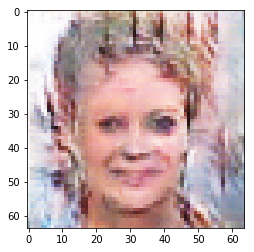

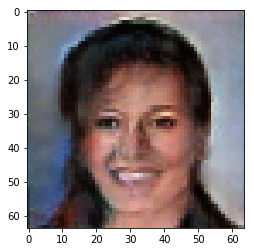

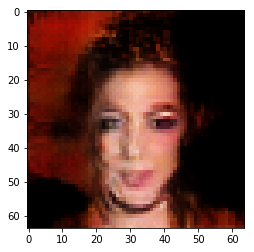

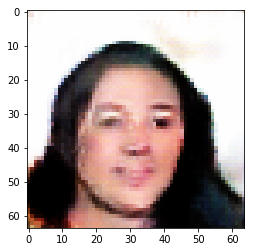

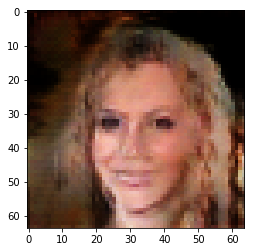

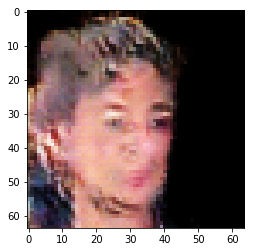

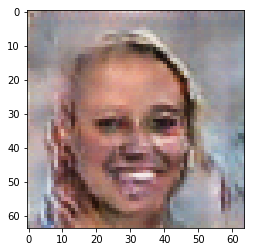

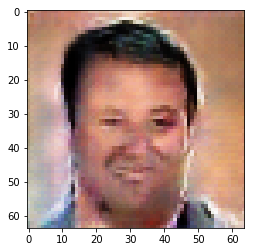

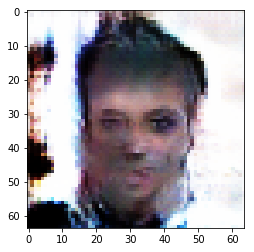

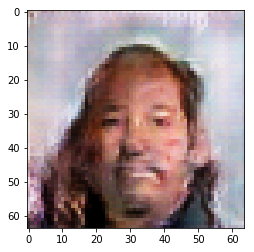

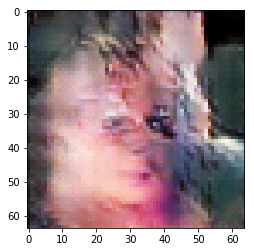

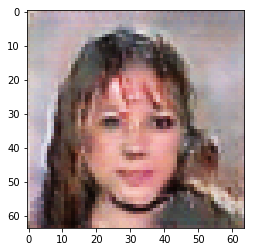

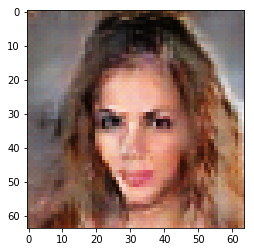

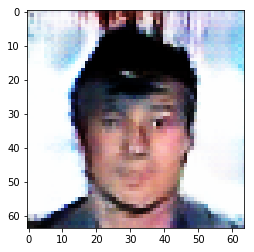

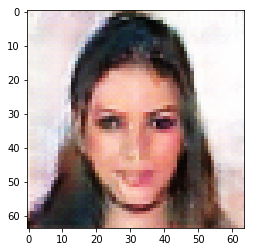

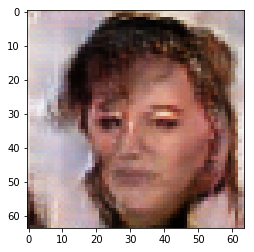

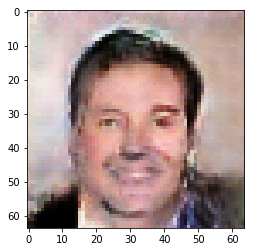

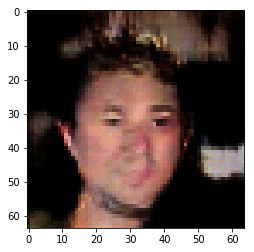

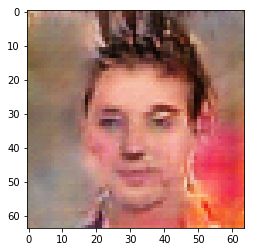

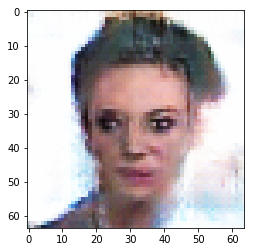

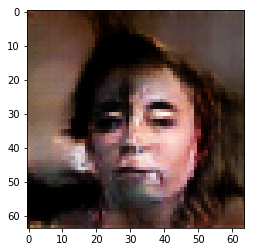

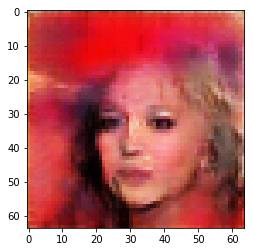

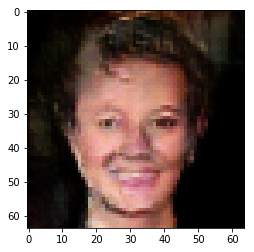

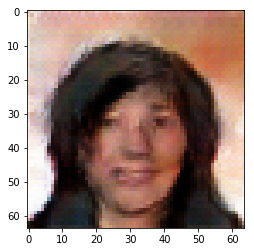

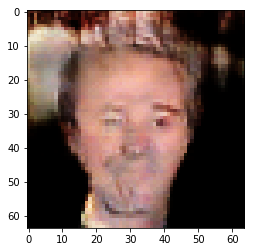

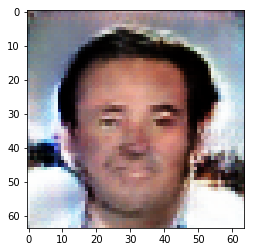

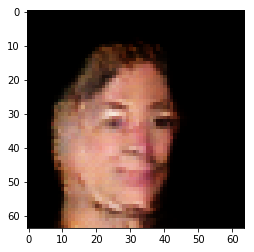

In [218]:
# without smile vector
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


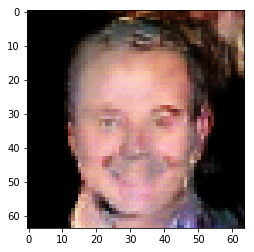

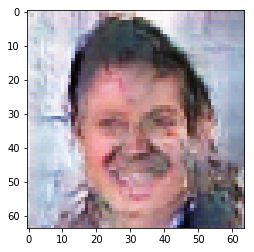

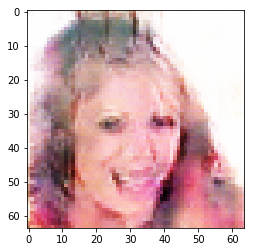

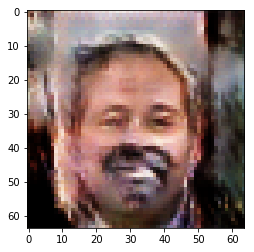

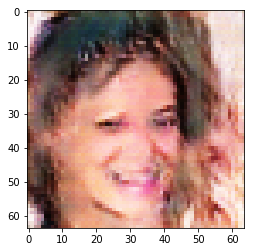

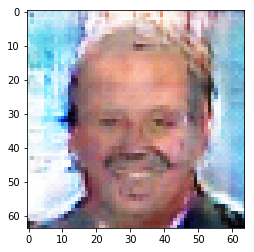

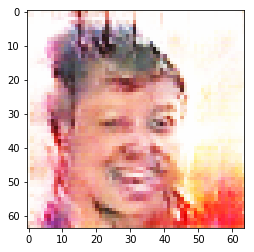

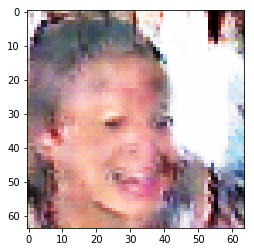

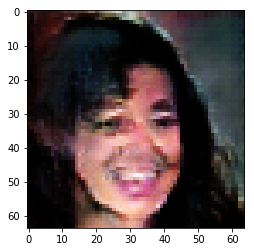

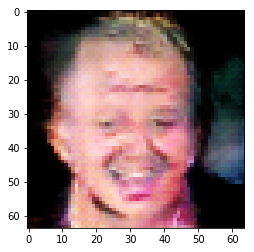

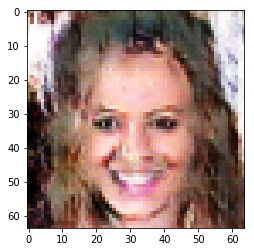

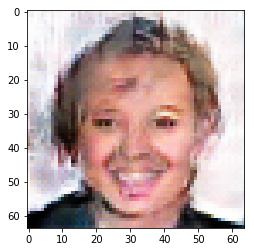

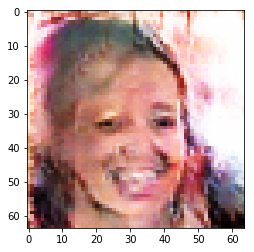

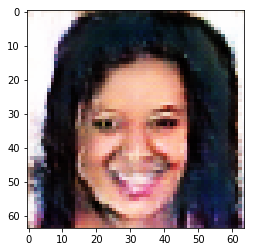

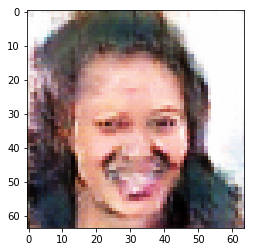

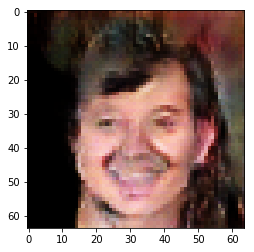

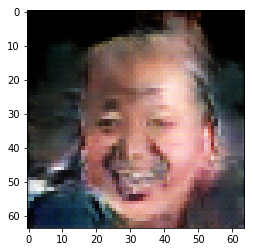

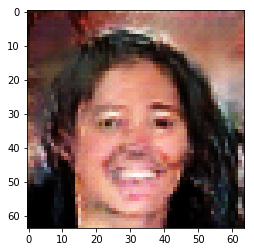

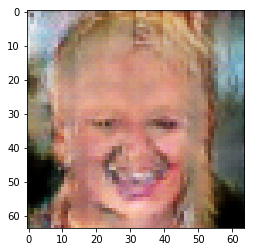

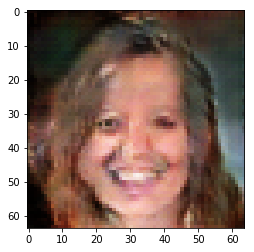

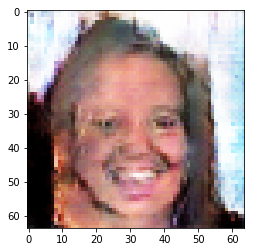

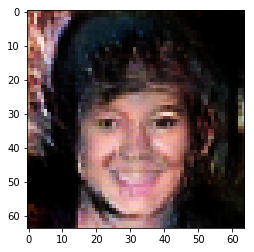

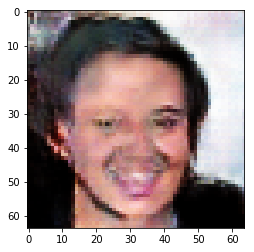

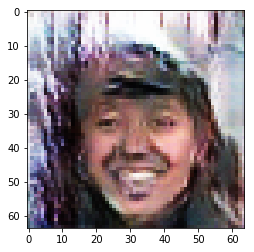

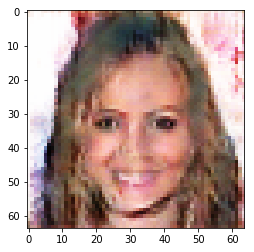

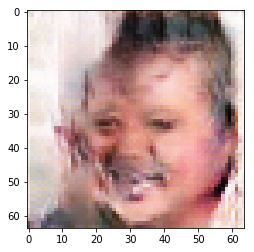

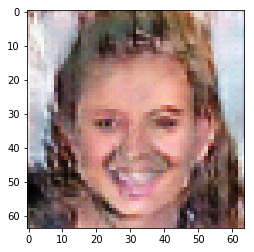

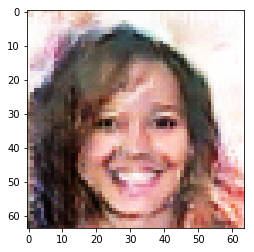

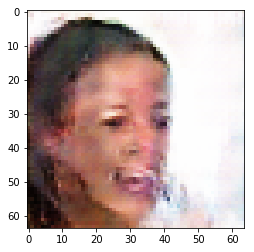

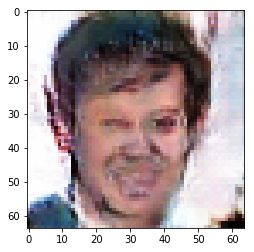

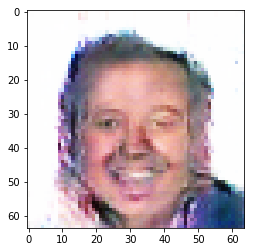

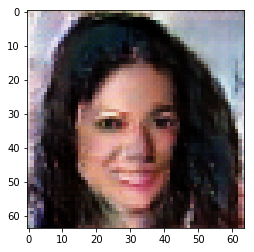

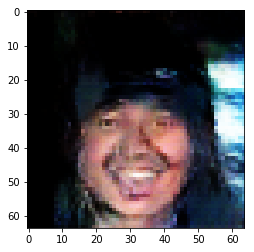

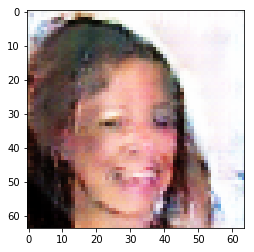

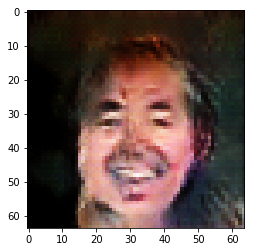

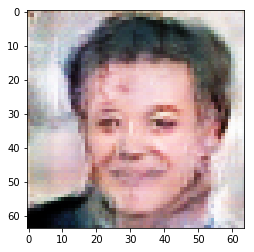

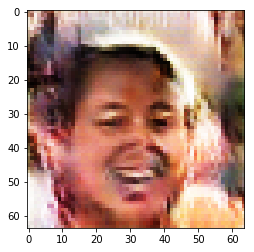

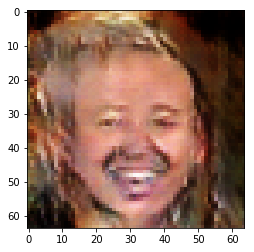

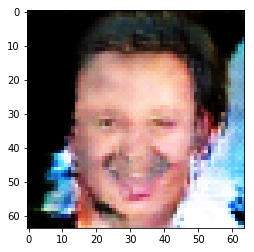

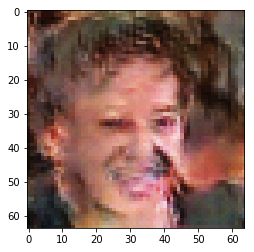

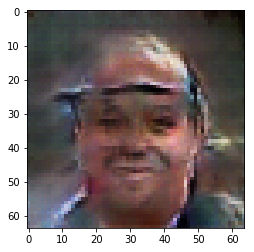

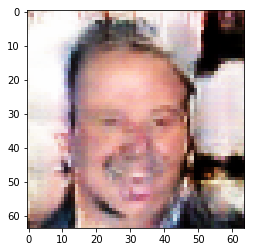

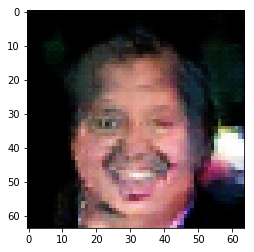

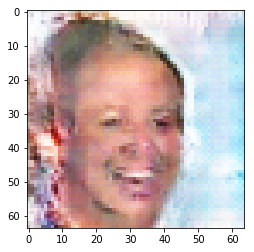

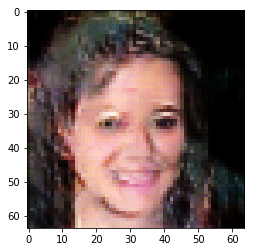

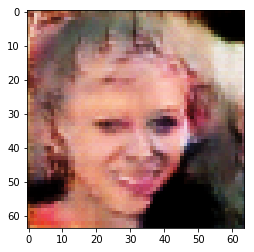

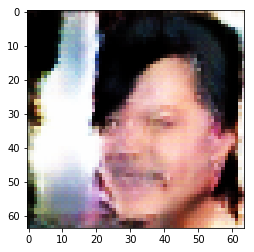

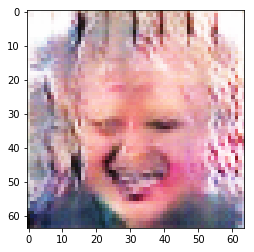

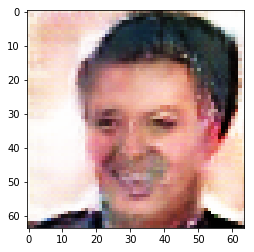

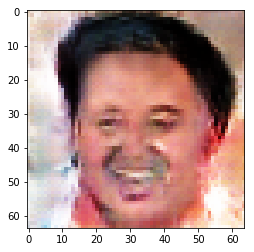

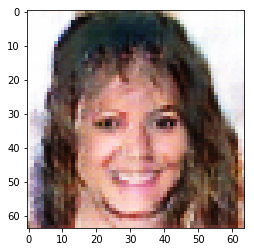

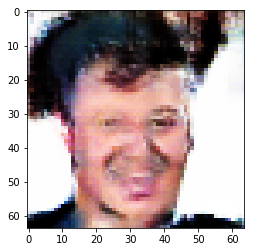

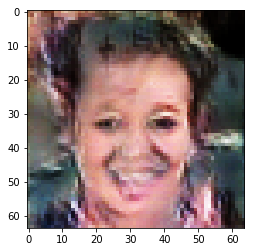

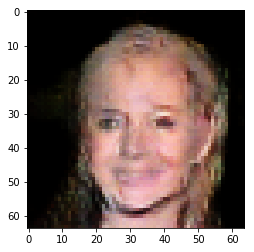

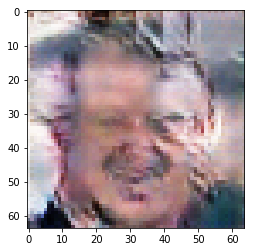

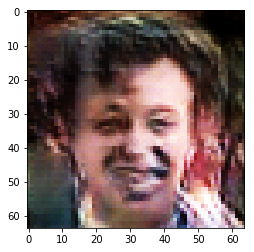

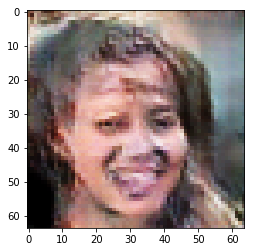

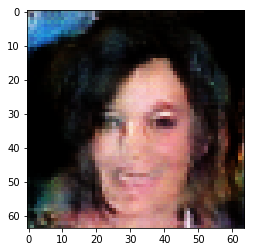

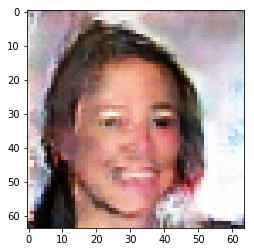

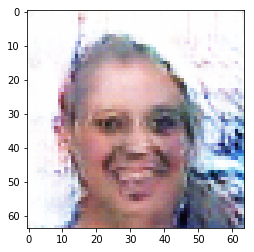

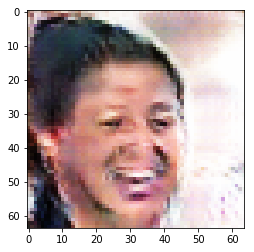

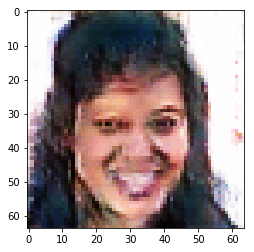

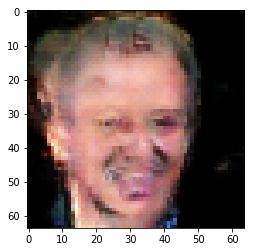

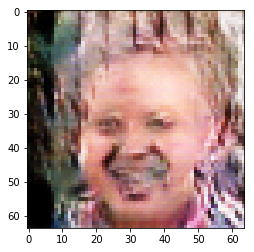

In [219]:
# WITH smile vector
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: smile_batch, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


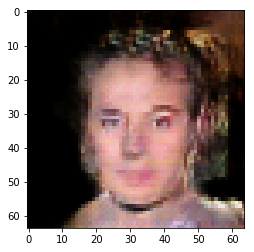

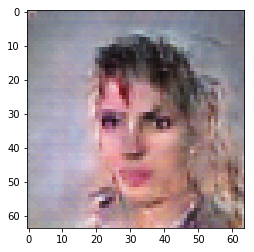

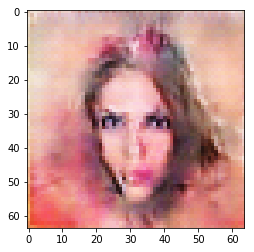

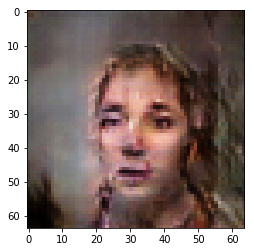

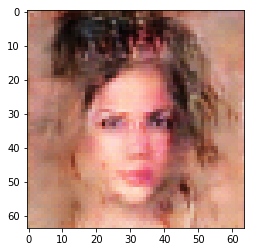

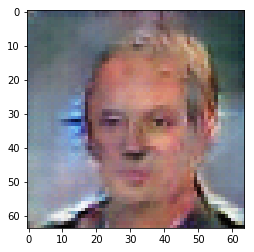

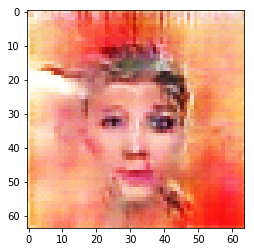

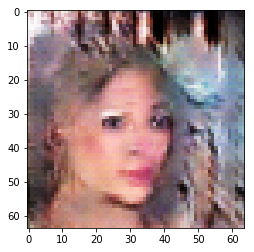

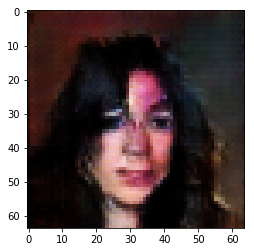

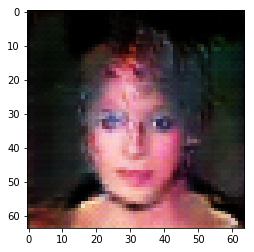

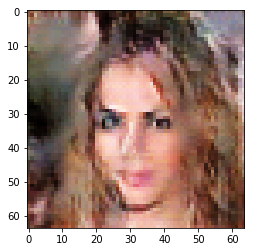

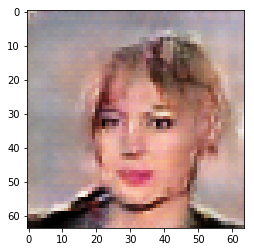

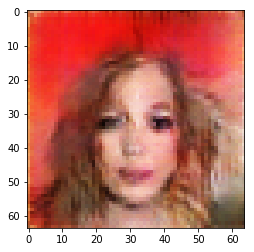

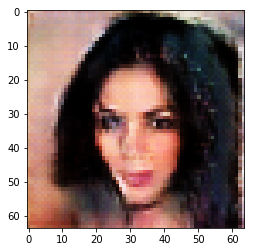

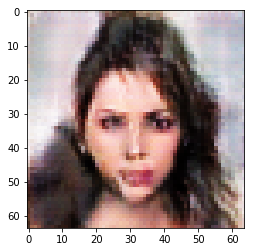

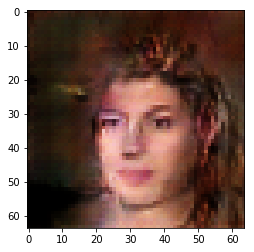

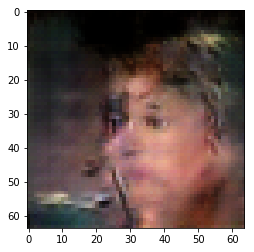

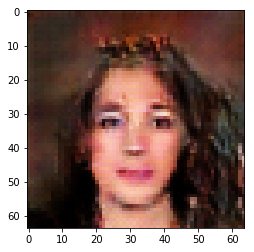

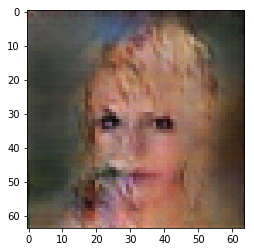

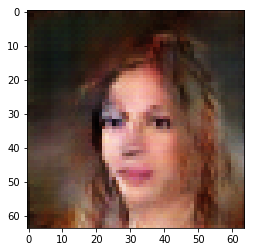

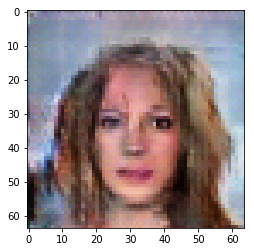

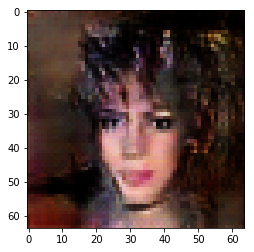

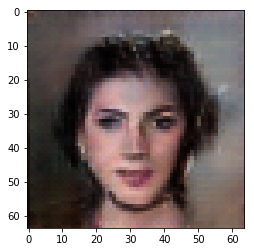

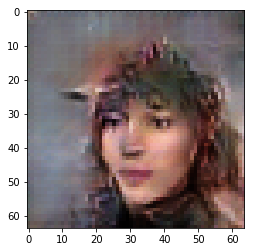

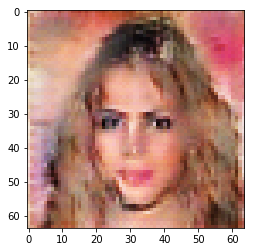

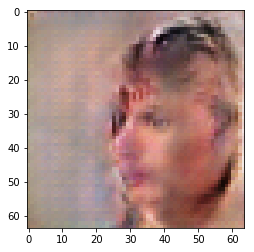

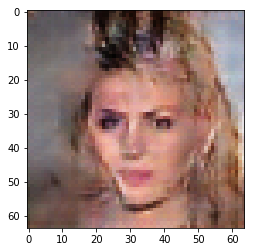

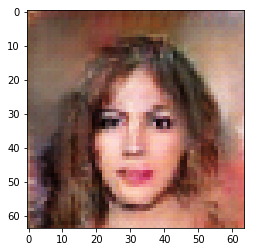

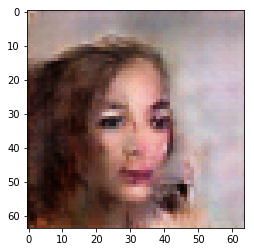

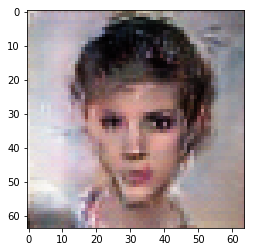

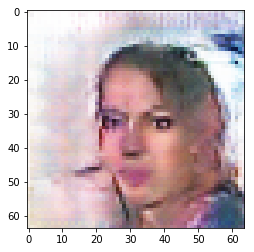

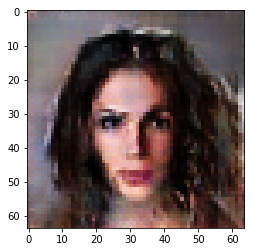

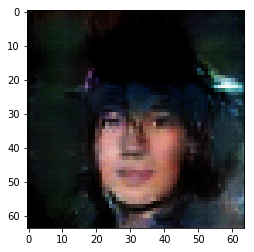

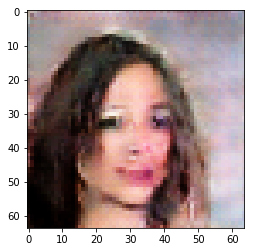

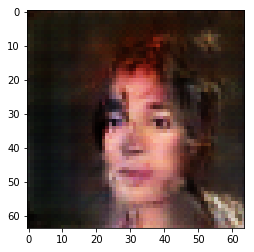

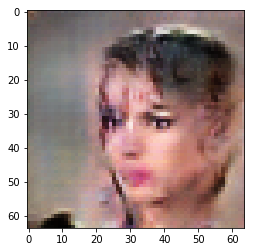

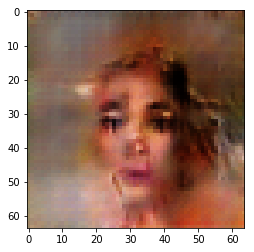

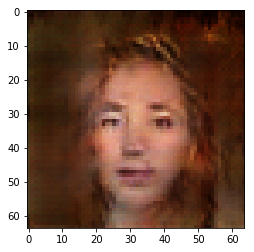

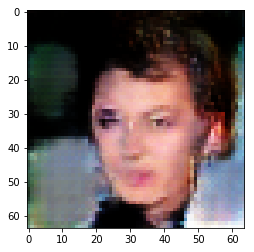

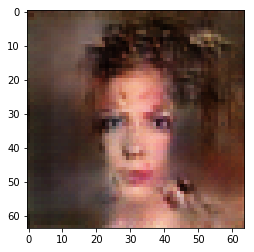

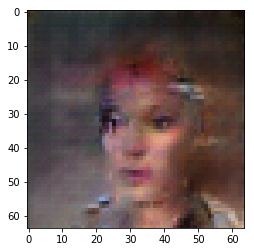

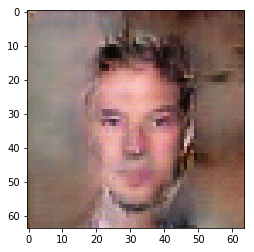

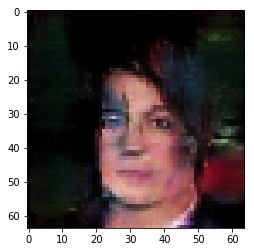

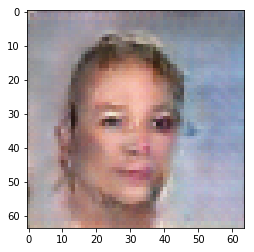

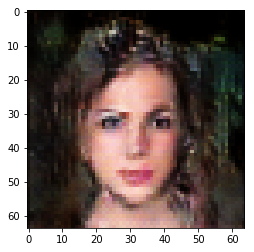

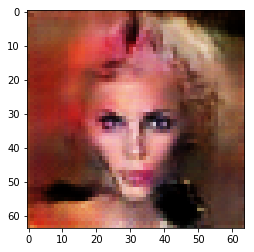

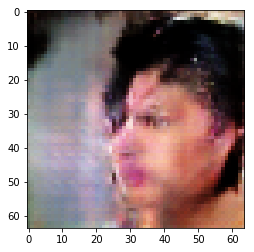

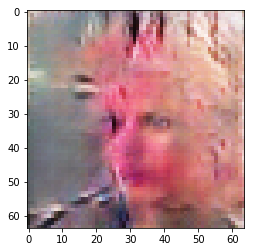

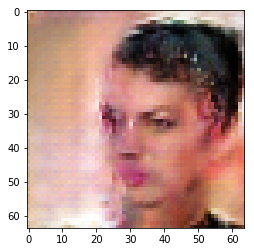

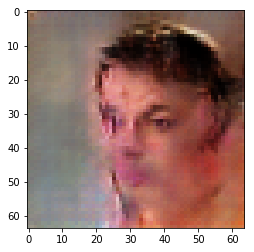

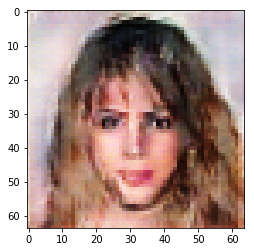

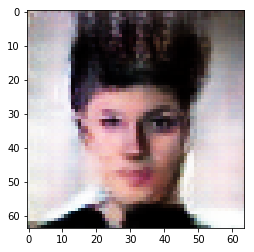

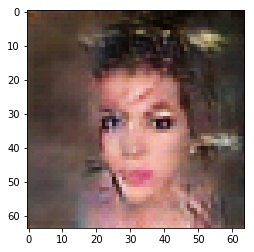

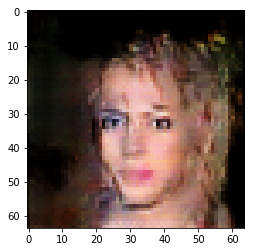

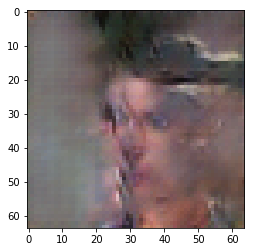

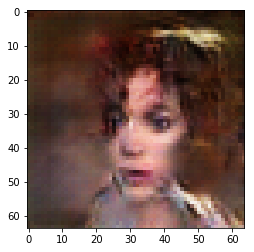

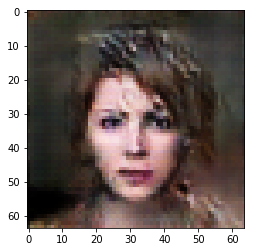

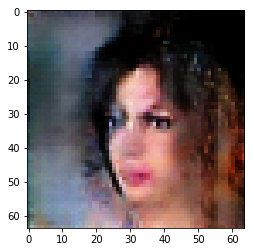

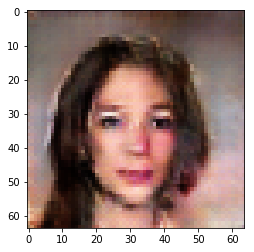

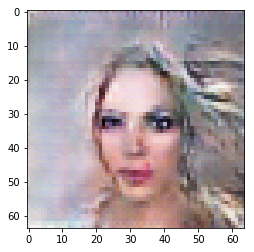

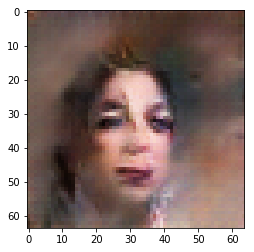

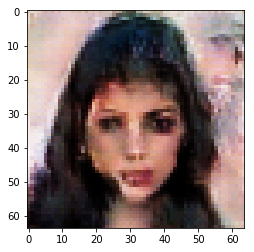

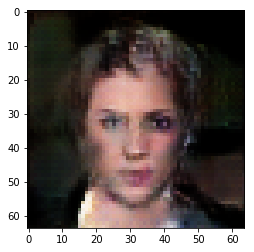

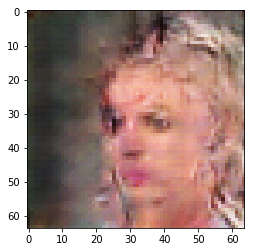

In [220]:
# WITH smile vector subtracted - these look terrible, I guess you can't subtract a smile
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: not_smiles_batch, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

If faces looks really cool, add bonus 1 point to your score.